<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Исследование-задачи" data-toc-modified-id="Исследование-задачи-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Исследование задачи</a></span></li><li><span><a href="#Борьба-с-дисбалансом" data-toc-modified-id="Борьба-с-дисбалансом-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Борьба с дисбалансом</a></span></li><li><span><a href="#Тестирование-модели" data-toc-modified-id="Тестирование-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование модели</a></span></li></ul></div>

# Отток клиентов

Из «Бета-Банка» стали уходить клиенты. Каждый месяц. Немного, но заметно. Банковские маркетологи посчитали: сохранять текущих клиентов дешевле, чем привлекать новых.

Нужно спрогнозировать, уйдёт клиент из банка в ближайшее время или нет. Вам предоставлены исторические данные о поведении клиентов и расторжении договоров с банком. 

Постройте модель с предельно большим значением *F1*-меры. Чтобы сдать проект успешно, нужно довести метрику до 0.59. Проверьте *F1*-меру на тестовой выборке самостоятельно.

Дополнительно измеряйте *AUC-ROC*, сравнивайте её значение с *F1*-мерой.

Источник данных: [https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling](https://www.kaggle.com/barelydedicated/bank-customer-churn-modeling)

## Подготовка данных

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [3]:
data = pd.read_csv('/datasets/Churn.csv')
data.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Целевой признак Exited — факт ухода клиента — категориальный признак => задача будет достигаться методами классификации.

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


In [5]:
data['Tenure'] = data['Tenure'].fillna(-1)

In [6]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [7]:
data['Geography'].unique()

array(['France', 'Spain', 'Germany'], dtype=object)

Датасет содержить 10000 строк, явных пропусков не обнаружено.
Требуемые изменения:

-RowNumber — столбец дублирует информацию стандартного датафрейма и не несетя ценности для обучения модели. Поэтому столбец можно удалить

-CustomerId — является идентификатором пользователя (по данному столбцу значению необходимо проверить наличие дубликатов) и если отсутсвуют — стоблец также можно удалить.

-Surname — является идентифицирующей пользователя информацией, содержит 2932 уникальных значений (данные kaggle), что сильно усложняет задачу, но не несет ценности для качества будущей модели — столбец можно удалить.

-CreditScore — следует проверить распределение и сохранить данный столбец.

-Geography — всего 3 уникальных значения France', 'Spain', 'Germany' — выполнить преобразование OHE / ordinal encoding

-Gender — значение преобразовать — OHE / ordinal encoding.

Age — Exited — тип данных верны, требуется проработка OHE.

In [8]:
data.duplicated().sum()

0

In [9]:
data['CustomerId'].value_counts().sum()

10000

Удалим столбцы-идентификаторы, не представляющие ценностия для алгоритма

In [10]:
for_drop = ['RowNumber','CustomerId', 'Surname']
data_ml = data.drop(for_drop, axis=1)
data_ml.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


Данные подготовим методом OHE

In [11]:
data_ml = pd.get_dummies(data_ml, drop_first=True)
data_ml.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,1,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,1,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,0,1,0


In [12]:
data_ml.shape

(10000, 12)

В новом датафрейме мы получили 12 столбцов.
Столбец Geography содержал 3 класса, Gender_Male 2 класса — в результате мы получили только 2 и 1 столбцов соответственно, что позволяет избежать дами-ловушки.

В нашем случае нет отдельно выделенной тестовой выборки, поэтому существющие данные мы делим на три выборки:

-обучающая 60% для обучения модели
-валидационная 20% для выбора лучшего алгоритма и оптимальных параметров
-тестовая 20% для финального теста лучшей модели.

In [13]:
features = data_ml.drop('Exited', axis=1)
target = data_ml['Exited']

In [14]:
features.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
0,619,42,2.0,0.00,1,1,1,101348.88,0,0,0
1,608,41,1.0,83807.86,1,0,1,112542.58,0,1,0
2,502,42,8.0,159660.80,3,1,0,113931.57,0,0,0
3,699,39,1.0,0.00,2,0,0,93826.63,0,0,0
4,850,43,2.0,125510.82,1,1,1,79084.10,0,1,0


In [15]:
target.head()

0    1
1    0
2    1
3    0
4    0
Name: Exited, dtype: int64

Разделение выборки произведем в 2 этапа:
-Выделим валидационную 60%
-Разделим оставшиеся 40% на 2 равные части (валидационная и тестовая)

In [16]:
#1. Выделим валидационную 60%
features_train, features_validtest, target_train, target_validtest = train_test_split(features,
                                                    target,
                                                    train_size=0.6,
                                                    random_state=12345, 
                                                    stratify=target)

In [17]:
print('Признаки обучающей выборки:',features_train.shape,  
      'Целевой признак обучающей выборки:', target_train.shape, 
      'Валидационная и тестовая вместе', features_validtest.shape, target_validtest.shape)

Признаки обучающей выборки: (6000, 11) Целевой признак обучающей выборки: (6000,) Валидационная и тестовая вместе (4000, 11) (4000,)


In [18]:
#2. Разделим оставшиеся 40% на 2 равные части (валидационная и тестовая)
features_valid, features_test, target_valid, target_test = train_test_split(features_validtest,
                                                    target_validtest,
                                                    train_size=0.5,
                                                    random_state=12345, 
                                                    stratify=target_validtest)

In [19]:
print(features_valid.shape, target_valid.shape, features_test.shape, target_test.shape)

(2000, 11) (2000,) (2000, 11) (2000,)


Полученые выбрки:
Обучающая
-features_train
-target_train

Валидационная
-features_valid
-target_valid

Тестовая
-features_test
-target_test

In [20]:
#импортируем библиотеку для стандартноо масштабирования
from sklearn.preprocessing import StandardScaler

In [21]:
features_train.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,549,49,6.0,124829.16,1,0,1,93551.36,1,0,0
9925,694,38,-1.0,195926.39,1,1,1,85522.84,0,0,0
8746,660,34,8.0,106486.66,2,0,1,182262.66,0,0,1
660,632,41,-1.0,81877.38,1,1,1,33642.21,1,0,0
3610,580,56,1.0,131368.30,1,1,0,106918.67,0,0,0


In [22]:
numeric = ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'EstimatedSalary']

In [23]:
#Создадим объект этой структуры и настроим его на обучающих данных:
scaler = StandardScaler()
scaler.fit(features_train[numeric])

StandardScaler()

In [24]:
#Масштабируем численные признаки обучающей выборки 
features_train[numeric] = scaler.transform(features_train[numeric])
features_train.head()

/tmp/ipykernel_431/3736596033.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[numeric] = scaler.transform(features_train[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
2837,-1.040434,0.953312,0.474986,0.774657,-0.914708,0,1,-0.119110,1,0,0
9925,0.454006,-0.095244,-1.675197,1.910540,-0.914708,1,1,-0.258658,0,0,0
8746,0.103585,-0.476537,1.089324,0.481608,0.820981,0,1,1.422836,0,0,1
660,-0.184996,0.190726,-1.675197,0.088439,-0.914708,1,1,-1.160427,1,0,0
3610,-0.720933,1.620574,-1.060859,0.879129,-0.914708,1,0,0.113236,0,0,0


In [25]:
#Масштабируем численные признаки валидационной выборки 
features_valid[numeric] = scaler.transform(features_valid[numeric])
features_valid.head()

/tmp/ipykernel_431/3140559217.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_valid[numeric] = scaler.transform(features_valid[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
6612,-1.524838,2.383160,-0.446521,1.011655,-0.914708,0,1,0.010275,0,0,0
519,0.587990,1.811221,0.474986,0.213192,-0.914708,0,1,0.453089,0,0,1
1609,-0.318980,-0.381213,1.089324,0.893896,-0.914708,1,0,-0.603508,0,0,0
3475,1.226991,-0.762506,-0.139352,-0.240363,0.820981,1,1,-1.621460,0,0,1
2707,-0.133464,-0.095244,-0.446521,0.447305,-0.914708,0,0,0.338574,0,0,0


In [26]:
#Масштабируем численные признаки тестовой выборки 
features_test[numeric] = scaler.transform(features_test[numeric])
features_test.head()

/tmp/ipykernel_431/2594626460.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_test[numeric] = scaler.transform(features_test[numeric])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
657,-0.504497,1.429928,-1.060859,0.873883,0.820981,1,1,1.725255,1,0,0
2083,-1.195031,-1.429769,-1.060859,-1.219673,-0.914708,1,1,1.203665,0,0,1
3234,-1.267176,0.762665,-1.060859,-1.219673,-0.914708,1,0,-1.374743,0,0,1
1551,0.825039,1.239281,0.782155,-1.219673,0.820981,0,1,0.382306,0,1,0
2344,0.660135,0.953312,-0.139352,0.267087,-0.914708,1,0,-1.613578,1,0,0


В результате мы получили масштабированные признаки для трех выборок. Перейдем к исследованию задачим моделями машинного обучения.

## Исследование задачи

Для исследовательского обучения используем три модели

2.1 Обучение модел

In [27]:
#импорт библиотек трех моделей
#Деревое решений
from sklearn.tree import DecisionTreeClassifier

#Случайный лес 
from sklearn.ensemble import RandomForestClassifier

#Логистическая регрессия
from sklearn.linear_model import LogisticRegression

In [28]:
#метика accuracy
from sklearn.metrics import accuracy_score

#матрица ошибок
from sklearn.metrics import confusion_matrix

#полнота
from sklearn.metrics import recall_score

#точность
from sklearn.metrics import precision_score

#F-1 мера
from sklearn.metrics import f1_score

#AUC-ROC
from sklearn.metrics import roc_auc_score

#ROC-кривая
from sklearn.metrics import roc_curve

2.1. Точность разных моделей

In [29]:
def all_models_accuracy(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=123)
    DTC_score = model_DTC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    RFC_score = model_RFC.fit(features_train, target_train).score(features_valid, target_valid)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    LgR_score = model_LgR.fit(features_train, target_train).score(features_valid, target_valid)
    print("Точность:" "дерево решений", DTC_score, "случайный лес ", RFC_score, "логистческая регрессия", LgR_score)

In [30]:
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.7945 случайный лес  0.8645 логистческая регрессия 0.811


2.2 Проверка баланса классов выборки

In [31]:
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [32]:
target_valid.value_counts(normalize = 1)

0    0.796
1    0.204
Name: Exited, dtype: float64

У обучающией и валидационной выборок наблюдается заметный дисбаланс класов. Ответы 0 ≈80% , 1 ≈ 20%
Можно ожидать, что результаты предсказаний моделей будут сильно склоняться к одному варианту ответов.

2.3 Проверка адекватности

Проверим какое соотношение ответов выдает каждая модель.

In [33]:
def all_models_share(features_train, target_train, features_valid, target_valid):
    model_DTC = DecisionTreeClassifier(random_state=123)
    model_DTC.fit(features_train, target_train)
    DTC_share = pd.Series(model_DTC.predict(features_valid)).value_counts(normalize = 1)
    
    
    
    model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
    model_RFC.fit(features_train, target_train)
    RFC_share = pd.Series(model_RFC.predict(features_valid)).value_counts(normalize = 1)
    
    model_LgR = LogisticRegression(solver = 'liblinear')
    model_LgR.fit(features_train, target_train)
    LgR_share = pd.Series(model_LgR.predict(features_valid)).value_counts(normalize = 1)
    

    
    print("Доли ответов:" "дерево решений", DTC_share, "случайный лес ", RFC_share, "логистческая регрессия", LgR_share , end='')

In [34]:
all_models_share(features_train, target_train, features_valid, target_valid)

Доли ответов:дерево решений 0    0.7845
1    0.2155
dtype: float64 случайный лес  0    0.8675
1    0.1325
dtype: float64 логистческая регрессия 0    0.931
1    0.069
dtype: float64

Логистичесая регрессия показывала самую высокую точность, но данная модель выдает 100% одинаковый результат = 0
Сравним качество предсказаний с константной моделью. За константу примем пример 0, так как это значение встречается 80% случаев

In [35]:
#Создаем константную модель
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.shape

(2000,)

In [36]:
accuracy_score_constant = accuracy_score(target_valid, target_predict_constant)
accuracy_score_constant

0.796

Точность моделей: дерево решений 0.2915 случайный лес 0.5 логистческая регрессия 0.796
Точность константной модели: 0.796
Ни одна модель не показал результат выше констентной модели, вероятно проблема кроется в дисбалансе классов.

Чтобы разобраться подбробнее ознакомися с матрицой ошибок для каждой модели.

In [37]:
#матрица ошибок для дерево решений
model_DTC = DecisionTreeClassifier(random_state=123)
model_DTC.fit(features_train, target_train)
DTC_prediction = model_DTC.predict(features_valid)
confusion_matrix(target_valid, DTC_prediction)

array([[1375,  217],
       [ 194,  214]])

Дерево решений склонно выдавать позитивные предсказания, очень высокое количество ложных позитивных предсказания (FP)
Изучим полноту, точность и F1-меру

In [38]:
def rec_prec_f1(target_valid, prediction):
    print("Полнота" , recall_score(target_valid, prediction))
    print("Точность", precision_score(target_valid, prediction))
    print("F1-мера", f1_score(target_valid, prediction))
    print("AUC-ROC", roc_auc_score(target_valid, prediction))

In [39]:
#полнота, точность и F1-мера для дерева решений
rec_prec_f1(target_valid, DTC_prediction)

Полнота 0.5245098039215687
Точность 0.4965197215777262
F1-мера 0.5101311084624552
AUC-ROC 0.694101635629126


Низкое значние F1- меры свидетельствует о низком качестве модели, проблема в точности.

In [40]:
#матрица ошибок для случайного леса
model_RFC = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC.fit(features_train, target_train)
RFC_prediction = model_RFC.predict(features_valid)
confusion_matrix(target_valid, RFC_prediction)

array([[1528,   64],
       [ 207,  201]])

Случайный лес примерно равную пропорцию позитивных и негативных предсказаний, выдает заметно больше качественных предсказаний, но также сильно склоняется к ложно позитивным предсказаниям (FP)

In [41]:
#полнота, точность и F1-мера для случайного леса
rec_prec_f1(target_valid, RFC_prediction)

Полнота 0.49264705882352944
Точность 0.7584905660377359
F1-мера 0.5973254086181279
AUC-ROC 0.7262230268992019


Низкое значние F1- меры свидетельствует о низком качестве модели, проблема в точности.

In [42]:
#матрица ошибок для логистической регрессии
model_LgR = LogisticRegression(solver = 'liblinear')
model_LgR.fit(features_train, target_train)
LgR_prediction = model_LgR.predict(features_valid)
confusion_matrix(target_valid, LgR_prediction)

array([[1538,   54],
       [ 324,   84]])

Для логистической регрессии расчитаем метрику AUC-ROC

In [43]:
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)

auc_roc_LgR

0.7875914498965415

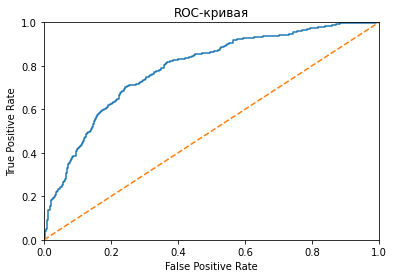

In [44]:
fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

In [45]:
LgR_probabilities_one_valid = model_LgR.predict_proba(features_valid)[:, 1]

auc_roc_LgR = roc_auc_score(target_valid, LgR_probabilities_one_valid)

auc_roc_LgR

0.7875914498965415

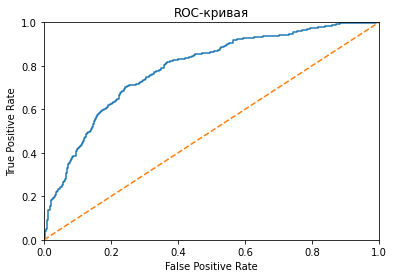

In [46]:
fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Score 0.733
AUC-ROC 0.7938097349492561


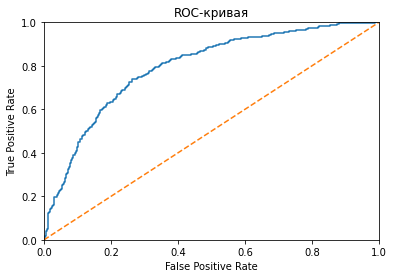

In [47]:
#попробуем обучать логистическую регресию сбалансировав классы
model_LgR = LogisticRegression(solver = 'liblinear', class_weight='balanced')
model_LgR.fit(features_train, target_train)
LgR_probabilities_one_valid_class_weight = model_LgR.predict_proba(features_valid)[:, 1]
print("Score", model_LgR.score(features_valid, target_valid))
print("AUC-ROC", roc_auc_score(target_valid, LgR_probabilities_one_valid_class_weight))

fpr, tpr, thresholds = roc_curve(target_valid, LgR_probabilities_one_valid_class_weight) 
plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Точность предсказаний не улучшилась.

Логистическая регрессия выдает 100% негативных предсказаний — высокая точность модели объясняется высокой долей негативных ответов в валидационной выборке.

Перейдем к формированию сбалансированных выборок

## Борьба с дисбалансом

3.1 Борьба с дисбалансом

In [48]:
from sklearn.utils import shuffle

Как мы выяснили ранее в нашей выборке отрицательны ответов ≈80% , положитительных ≈ 20%.
Нам необходмо увеличить количество положительных ответов в 4 раза для достижения баланса.

-Разделим обучающую выборку на отрицательные и положительные объекты;
-Скопируем несколько раз положительные объекты;
-С учётом полученных данных создадим новую обучающую выборку;
-Перемешаем данные: идущие друг за другом одинаковые вопросы не помогут обучению.
-Обучим новые модели

In [49]:
#Ознакомимся с пероначальным распределением классов
target_train.value_counts(normalize = 1)

0    0.796333
1    0.203667
Name: Exited, dtype: float64

In [50]:
target_train.shape

(6000,)

<AxesSubplot:ylabel='Frequency'>

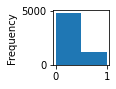

In [51]:
target_train.plot(kind ='hist', bins=2, figsize=(1,1))

In [52]:
#создадим функцию для увеличения представленной класса в выборке 
def upsample(features, target, repeat, upsampled_сlass):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]
    
    if upsampled_сlass == 0:
        features_upsampled = pd.concat([features_zeros]* repeat + [features_ones] )
        target_upsampled = pd.concat([target_zeros]* repeat + [target_ones] )
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
        
    elif upsampled_сlass == 1:
        features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
        target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
        features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    else:
        features_upsampled = 0
        target_upsampled = 0  
        
        
       
    return features_upsampled, target_upsampled
    "Функция принимаем значение признаков (features[]), целевого признака (target[]), repeat(int / float), "
    " класс который будет увеличен (upsampled_сlass (0 or 1))"

In [53]:
#Протестируем функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 0)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

0    0.939904
1    0.060096
Name: Exited, dtype: float64
(20334,)


In [54]:
#Протестируем функцию (верное значение)
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 3)
features_train_upsampled

0

In [55]:
#применим функцию upsample 
#увеличим количество положительных ответов в 4 раза
features_train_upsampled, target_train_upsampled = upsample(features_train, target_train, 4, 1)
print(target_train_upsampled.value_counts(normalize = 1))
print(target_train_upsampled.shape)

1    0.50569
0    0.49431
Name: Exited, dtype: float64
(9666,)


<AxesSubplot:ylabel='Frequency'>

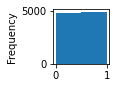

In [56]:
target_train_upsampled.plot(kind ='hist', bins=2, figsize=(1,1))

Мы получили сбалансированное количество классов, перейдем к обучению моеделей на новы данных.

3.2 Обучение моделей на сбаланированной выборке

Точность (score)

In [57]:
#точность моделей на выборке с дисбалансом
all_models_accuracy(features_train, target_train, features_valid, target_valid)

Точность:дерево решений 0.7945 случайный лес  0.8645 логистческая регрессия 0.811


In [58]:
#точность моделей на сбалансированной выборке
all_models_accuracy(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

Точность:дерево решений 0.8065 случайный лес  0.852 логистческая регрессия 0.7255


Точность моделей изменились незначительно, но проверим изменилось ли качество ответов.

Качество предсказаний

In [59]:
#Решающее дерево
model_DTC_upsampled = DecisionTreeClassifier(random_state=123)
model_DTC_upsampled.fit(features_train_upsampled, target_train_upsampled)
DTC_prediction_upsampled = model_DTC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, DTC_prediction_upsampled)

Полнота 0.5122549019607843
Точность 0.5264483627204031
F1-мера 0.5192546583850932
AUC-ROC 0.6970822248497388


In [60]:
#Случайный лес
model_RFC_upsampled = RandomForestClassifier(random_state=12345, n_estimators = 100)
model_RFC_upsampled.fit(features_train_upsampled, target_train_upsampled)
RFC_prediction_upsampled = model_RFC_upsampled.predict(features_valid)
rec_prec_f1(target_valid, RFC_prediction_upsampled)

Полнота 0.5759803921568627
Точность 0.6564245810055865
F1-мера 0.6135770234986945
AUC-ROC 0.7493595428120997


In [61]:
#Логистическая регрессия
model_LgR_upsampled = LogisticRegression(solver = 'liblinear')
model_LgR_upsampled.fit(features_train_upsampled, target_train_upsampled)
LgR_prediction_upsampled = model_LgR_upsampled.predict(features_valid)
rec_prec_f1(target_valid, LgR_prediction_upsampled)

Полнота 0.7426470588235294
Точность 0.40562248995983935
F1-мера 0.5246753246753246
AUC-ROC 0.7318762932308602


Показаели всех моделей улучшились.
Лучшие результаты показывает алгоритм случайный лес (RandomForestClassifier). На валидационной выборке RandomForestClassifier уже показывает резульаты F1 меры = 0.63, что выше целевого целевого значения.
Попробуем улучшить модель путем изменения параметров.

3.3 Улучшение модели

In [62]:
from itertools import product
import tqdm

In [63]:
def RandomForestQuality(features_train, target_train, features_valid, target_valid):
    
    #Параметры для перебора
    bootstrap = [True, False]
    class_weight = ['balanced', 'balanced_subsample', None]
    max_features = ['auto', 'sqrt', 'log2'] 
    max_depth = [] #диапазон изменения параметра мксимальной глубины каждого дерева
    for i in range(1, 20):
        max_depth.append(i)

    #Метод itertools.product для перебора нескольких параметров
    myproduct = product(bootstrap, class_weight, max_features, max_depth)
    
    #Строки, котоыре будут наполняться циклом при переборе параметров
    bootstrap_table = []
    class_weight_table = []
    features_table = []
    depth_table = []
    f1_table = []
    recall_table = []
    precision_table = []
    score_train_table = []
    score_valid_table = []
    
    #Цикл перебора всех параметров: bootstrap, class_weight, max_features, max_depth
    for p in tqdm.tqdm(myproduct,):
        #Обучение модели
        model_forest = RandomForestClassifier(
            bootstrap=p[0] , class_weight= p[1], max_features = p[2], max_depth = p[3], 
            n_estimators = 10, random_state=12345)
        model_forest.fit(features_train, target_train)
        prediction = model_forest.predict(features_valid) #предсказание целевого признака
        
        #расчет параметров
        f1 = f1_score(target_valid, prediction)
        recall = recall_score(target_valid, prediction)
        precision = precision_score(target_valid, prediction)
        score_train = model_forest.score(features_train, target_train)
        score_valid = model_forest.score(features_valid, target_valid)
        
        #внесение значиний параметров в строки
        bootstrap_table.append(p[0])
        class_weight_table.append(p[1])
        features_table.append(p[2])
        depth_table.append(p[3])

        #внесение значений метрик в строки
        f1_table.append(f1)
        recall_table.append(recall)
        precision_table.append(precision)
        score_train_table.append(score_train)
        score_valid_table.append(score_valid)
               
    
    #Обоъединение строк в датафрем
    quality_table = pd.DataFrame(data = (
        bootstrap_table, class_weight_table, features_table, depth_table, 
        f1_table, recall_table, precision_table, score_train_table, score_valid_table)).T
    quality_table.columns = (
        'bootstrap', 'class_weight', 'max_features', 'max_depth', 'f1', 'recall', 'precision', 'score_train', 'score_valid')
    return quality_table

    "4 параметра: features_train, target_train — признаки и целевой признак обучающей выборки"
    "features_valid, target_valid — признаки и целевой признак обучающей выборки"

In [64]:
%%time
quality_table = RandomForestQuality(features_train_upsampled, target_train_upsampled, features_valid, target_valid)

342it [00:43,  7.90it/s]

CPU times: user 42.2 s, sys: 431 ms, total: 42.7 s
Wall time: 43.3 s


In [65]:
quality_table.query('score_valid>=score_train').sort_values('f1', ascending = False).head()

,bootstrap,class_weight,max_features,max_depth,f1,recall,precision,score_train,score_valid
63,True,balanced_subsample,auto,7,0.630705,0.745098,0.546763,0.818953,0.822
82,True,balanced_subsample,sqrt,7,0.630705,0.745098,0.546763,0.818953,0.822
101,True,balanced_subsample,log2,7,0.630705,0.745098,0.546763,0.818953,0.822
253,False,balanced_subsample,sqrt,7,0.627884,0.767157,0.531409,0.811504,0.8145
215,False,balanced,log2,7,0.627884,0.767157,0.531409,0.811504,0.8145


Лучшие параметры модели:
model = RandomForestClassifier(bootstrap = True, class_weight = 'balanced', max_depth= 7, n_estimators = 10, random_state=12345)

Параметр "max_features" не влияет на параметры модели, оставляем параметр без изменений (default=”auto”).

Обучим финальную модель

In [66]:
model_RFC_final = RandomForestClassifier(
    bootstrap = True, class_weight = 'balanced', max_depth= 7,  n_estimators = 100, random_state=12345)
model_RFC_final.fit(features_train_upsampled, target_train_upsampled)

RandomForestClassifier(class_weight='balanced', max_depth=7, random_state=12345)

In [67]:
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='gini', max_depth=7, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=12345,
                       verbose=0, warm_start=False)

RandomForestClassifier(class_weight='balanced', max_depth=7, random_state=12345)

In [68]:
model_RFC_final_prediction = model_RFC_final.predict(features_valid)
rec_prec_f1(target_valid, model_RFC_final_prediction)

Полнота 0.7573529411764706
Точность 0.5383275261324042
F1-мера 0.629327902240326
AUC-ROC 0.7954478273721548


Проверим финальную модель на адекватность

In [69]:
#Создаем константную модель
target_predict_constant = pd.Series([0]*len(target_valid))
target_predict_constant.value_counts()

0    2000
dtype: int64

In [70]:
#Сравним показатель точности (accuracy_score) константной модели и финальной
print('accuracy_score константой модели:', accuracy_score(target_valid, target_predict_constant))
print('accuracy_score финальной модели:', accuracy_score(target_valid, model_RFC_final_prediction))
#Дополнительно сравним AUC-ROC — единственный параметр подающийся сравнению, потому что константная подель содержит только негативные ответы
print('AUC-ROC константой модели:', roc_auc_score(target_valid, target_predict_constant))
print('AUC-ROC финальной модели:', roc_auc_score(target_valid, model_RFC_final_prediction))

accuracy_score константой модели: 0.796
accuracy_score финальной модели: 0.818
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.7954478273721548


Финальная модель показывает результаты лучше, чем константная модель — модель можно считать адекватной.

Вывод по результатам исследования


-В первоначальные данных наблюдался значительный дисбаланс (80% ответов целевого признака были негативными и только 20% позитивными), из-за чего обученная на этих данных модель не проходила проверку на адекватность. Все модели не первоначальных данных характеризовались высокой степенью ошибок и низким качеством взвешенной величины (F1) — модели показывали низкие результаты точности и полноты.

-Мы устранили дисбаланс классов в обучающей выборки методом upsampling — увеличили количество значений позитивного класса в 4 раза. Так мы достигли баланса классо в обучеющей выборки: 1 = 0.50569, 0 = 0.49431.

-На новых данных все модели показали результат выше, чем на несбалансированной выборке. Лучшие показатели были у модели случайного леса:
Полнота 0.5784313725490197
Точность 0.6880466472303207
F1-мера 0.6284953395472703
AUC-ROC 0.755610158636319

-Было принято решение продолжать улучшение модели на основании алгоритма случайный лес (RandomForestClassifier)

-Улучшение модели происходило путем цикла выбора параметров, которые показывали наиболее высокое значение F1 меры и не приводили модель к переобучению. Изменяемые параметры: bootstrap, class_weight, max_depth от 1 до 19 Параметр n_estimators был занижен для ускорения выполнения цикла

-Финальные параметры выбранной модели RandomForestClassifier(bootstrap = True, class_weight = 'balanced', max_depth= 7, n_estimators = 100, random_state=12345).
Результаты модели:
Полнота 0.755
Точность 0.549
F1-мера 0.636
AUC-ROC 0.798

-Финальная модель прошла проверку на адекватность в сравнении с контантной моделью: accuracy_score константой модели: 0.796
accuracy_score финальной модели: 0.8235
AUC-ROC константой модели: 0.5
AUC-ROC финальной модели: 0.798

## Тестирование модели

In [71]:
model_RFC_final
model_RFC_final_prediction = model_RFC_final.predict(features_test)
rec_prec_f1(target_test, model_RFC_final_prediction)

Полнота 0.7199017199017199
Точность 0.5167548500881834
F1-мера 0.6016427104722794
AUC-ROC 0.773949604458079


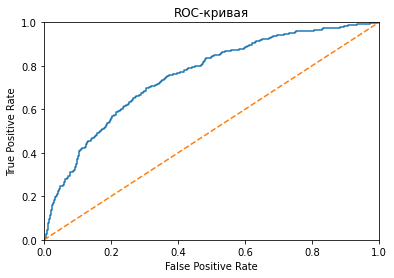

In [72]:
final_model_probabilities_one = model_LgR.predict_proba(features_test)[:, 1]

fpr, tpr, thresholds = roc_curve(target_test, final_model_probabilities_one) 

plt.figure()
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show()

Финальная достигла заданой метрики (F1 > 0.59) и показывает адекватные результаты.
Модель характеризуется высоким показателем полноты = 0.715 (min = 0, max = 1), поэтому она с высокой вероятностью предскажит уход клиента из банка.
Показатель точности не высокий = 0.517 (min = 0, max = 1) — модель верно предсказывает только половину ухода клиентов.
С точки зрения бизнеса полученная модель поможет маркетологам лучше определять килентов, которые могут уйти в ближайшее время. Важно, что модель покрывает большое количество клиентов, в данном случае это важнее чем точность.

Для улучшения модели следует использовать данные, отражающие отношения клиента с банком в динамике.